In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
from dataset import CustomImageDataset
from torch.utils.data import DataLoader
from skimage import exposure
from skimage.exposure import match_histograms
import ImageProcessing as IP
import torchvision.transforms as transforms

Declaring image directories

In [2]:
RGB_dir ='./Sample RGB/'
Depth_dir = './Sample Depth/'
ref_dir = './Manhatta Frames/'

Creating custom dataset

torch.Size([2, 3, 1080, 1920])


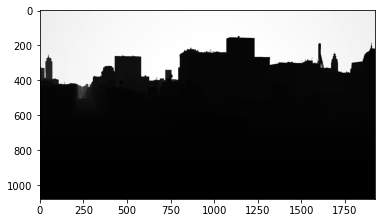

In [3]:
import importlib
importlib.reload(IP)

data = CustomImageDataset(img_dir= RGB_dir, depth_dir= Depth_dir, transform= IP.rgb_transform, histogram_matching= IP.histogram_matching)
data_loader = DataLoader(data, batch_size=2, shuffle=True) #Loads a random RGB, Depth couple from the dataset
rgb_img, depth_img = next(iter(data_loader)) #Unsqueezes and converts to tensor, may need to squeeze(0)
plt.imshow(rgb_img[0][0,:,:].squeeze().numpy(), cmap='gray')
plt.show()
plt.imshow(depth_img[0], cmap='gray')
plt.show()

In [4]:
rgb_img.shape

torch.Size([2, 3, 1080, 1920])

Transforming RGB images

In [5]:
#import importlib
#importlib.reload(IP)
#
#test_img = IP.rgb_transform(rgb_img[0])
#plt.imshow(test_img.transpose(0,2).transpose(0,1), cmap='gray')

Matching histogram

In [6]:
#matched_img = IP.histogram_matching(test_img, ref_dir)
#print(np.array(matched_img.shape[::-1]))
#matched_img.transpose_(0,2).transpose_(0,1)
#plt.imshow(matched_img.numpy(), cmap='gray')

Processing a scene for consistent depth prediction

In [7]:
for i,img in enumerate(rgb_img):
    cv.imwrite('./consistent_depth-main/color_full/' + str(i) + '.jpeg' , rgb_img[i].squeeze().numpy())


### Fine-tuning huggingface model: Intel/dpt-large

In [8]:
from transformers import AutoFeatureExtractor, DPTForDepthEstimation
from PIL import Image

extractor = AutoFeatureExtractor.from_pretrained("Intel/dpt-large")

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(output_dir="test_trainer")
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

inputs = np.empty(rgb_img.shape)
for i in range(0,rgb_img.shape[0]):
    inputs[i] = extractor(images=IP.transform_to_PIL(rgb_img[0]), return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= extractor(images=IP.transform_to_PIL(depth_img[0]), return_tensors="pt"),
    eval_dataset=depth_img[0],
    #compute_metrics=compute_metrics,
)


ValueError: could not convert string to float: 'pixel_values'

In [ ]:
trainer.train()

d:\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'Indexing with integers is not available when using Python based feature extractors'

In [ ]:
from transformers import TrainingArguments, Trainer
inputs = extractor(images=rgb_img[0], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
print(type(predicted_depth))

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(0),
    size=rgb_img.size,
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

depth.show()

d:\Anaconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


<class 'torch.Tensor'>


TypeError: upsample_bicubic2d(): argument 'output_size' must be tuple of ints, but found element of type builtin_function_or_method at pos 1

In [31]:
depth_img.shape

torch.Size([2, 1080, 1920])

In [37]:
torch.cat((depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0))).shape

TypeError: can't assign a torch.Size to a torch.FloatTensor

In [38]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

print(type(image))
# prepare image for the model


convert = transforms.PILToTensor()
print(convert(image).shape, rgb_img[0].shape)
inputs = feature_extractor(images=rgb_img[0], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= extractor(images=rgb_img[0], return_tensors="pt"),
    eval_dataset=torch.cat((depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0))).shape,
    #compute_metrics=compute_metrics,
)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([3, 480, 640]) torch.Size([3, 1080, 1920])


d:\Anaconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
